### Validation schema

In [1]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt


# working with files
import sys
import os
from pathlib import Path
import csv
import io

# to off warnings
import warnings
warnings.filterwarnings('ignore')

# validation schema 
import time
import sklearn
from sklearn.model_selection import train_test_split
from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# models
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
import catboost as cb

In [2]:
# # using ray engine for parallel calculation(for oprimization)
# %env MODIN_ENGINE=ray
# import modin.pandas as mpd

### Read data

In [3]:
%%time

# get directory path
dirpath = os.getcwd()

# set the data path
train_test_data_path = Path(dirpath) / 'data' / 'train_test_data'
print(train_test_data_path)
print(type(train_test_data_path))

# initiate dict for data
data = {}

# load data to dict
for file_path in train_test_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_csv(file_path)
        print(file_path.stem)

C:\Repository\DS-Intership\data\train_test_data
<class 'pathlib.WindowsPath'>
submission_example
test_data
train_data
CPU times: total: 14.8 s
Wall time: 15 s


### Validation schema creation

In [4]:
"""
    The following indexes will be used:
        
        from train_data:
          date_block_num
          shop_id
          item_category_id
          item_id
          item_cnt_month
        
        from test_data:
            shop_id',
            'item_id',
            'ID'

    Concept:
        Apply expanding window validation (except last month - target of competition)
        Monthly predictions
"""

class Validation:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 n_splits=5,
                 model=RandomForestRegressor(max_depth=1, n_estimators=1, random_state=42, n_jobs=-1),
                 params=None,
                 check_nans = True,
                 dropna = False,
                 check_infs = True,
                 validation_schema_plot=False
                ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.n_splits = n_splits
        self.model = model
        self.params = params
        self.tscv = TimeSeriesSplit(n_splits=self.n_splits)
    
        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_category_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_category_id',
                    'item_id',
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"
        
        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
            
        # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
        # Validation process visualisation
        if validation_schema_plot:
            split_history = {
                'Step': ["Step"+str(i) for i in range(1, self.n_splits+1)],
                'Train Data': [], 
                'Validation Data': []
            }
            for train, val in self.tscv.split(self.train_data[['item_id', 'shop_id', 'item_cnt_month']]):    
                split_history['Train Data'].append(train.max()-train.min())
                split_history['Validation Data'].append(val.max()-val.min())
            df = pd.DataFrame(split_history)
            print(df)
            sns.set(style="whitegrid")
            plt.figure(figsize=(6, 5))
            sns.barplot(x='Step', y='Train Data', data=df, color='skyblue', label='Train Data')
            sns.barplot(x='Step', y='Validation Data', data=df, color='salmon', label='Validation Data', bottom=df['Train Data'])
            plt.title('Distribution of data for training and validation')
            plt.xlabel('Validation step')
            plt.ylabel('Data quantity')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()
    
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def predict_target(self, predictions_by_ID = True):
        """
            Return target predictions in accordance with submission example
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.test_data
        
        # train model
        model = self.model
        model.fit(X_train, y_train)
        if predictions_by_ID:
            result = X_test.join(pd.DataFrame(index=X_test.index, data=model.predict(X_test.values),\
                                           columns=['item_cnt_month']))\
                                                [['item_id', 'shop_id', 'item_cnt_month']].\
                                merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                    .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
            result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
            return result
        else:
            return model.predict(X_val) 
    
    def evaluate(self):
        
        eval_report = {}
        train_errors = []
        val_errors = []
        is_boost = False
        
        # Evaluation loop
        step = 0
        for train, val in self.tscv.split(self.y):
            
            # Initialize steps and timer
            step += 1
            ts = time.time()

            # Split data step
            
            y_train, y_val = self.y.iloc[train].item_cnt_month, self.y.iloc[val].item_cnt_month
            X_train, X_val = self.X.iloc[train], self.X.iloc[val]            

            # Train step
            rng = np.random.RandomState(42)
            model = self.model
            
            if isinstance(model, sklearn.ensemble._forest.RandomForestRegressor):
                model = self.model
                model.fit(X_train, y_train)
                y_pred_val = model.predict(X_val)
                y_pred_train = model.predict(X_train)
                val_error = [self.calculate_metrics(y_pred_val, y_val)]
                train_error = [self.calculate_metrics(y_pred_train, y_train)]
                
            else:
                is_boost=True
                
                if isinstance(model, cb.core.CatBoostRegressor):
                    # Split
                    train_data = cb.Pool(X_train, label=y_train)
                    valid_data = cb.Pool(X_val, label=y_val)

                    # Train 
                    model.fit(train_data, eval_set=valid_data)

                    # Get error report
                    evals_result = model.get_evals_result()
                    train_error = evals_result['learn']['RMSE']
                    val_error = evals_result['validation']['RMSE']

                if isinstance(model, XGBRegressor):
                    model = self.model
                    model.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_val, y_val)], verbose=25)

                    # Get error report
                    evals_result = model.evals_result()
                    train_error = evals_result['validation_0']['rmse']
                    val_error = evals_result['validation_1']['rmse']

                if isinstance(model, lgb.sklearn.LGBMRegressor):
                    assert self.params is not None, "params is None"
                    train_data = lgb.Dataset(X_train, label=y_train)
                    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
                    model.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)])

                    # Get error report
                    evals_result = model.evals_result_
                    train_error = evals_result['training']['l2']
                    val_error = evals_result['valid_0']['l2']

                train_errors.append(train_error)
                val_errors.append(val_error)
            
            # Calculate time required for step
            time_info = time.time() - ts
            
            # Metrics calucaltion step
            eval_report["step"+str(step)] = {"Train/Validation error": [train_error[-1], val_error[-1]]}
            eval_report["step"+str(step)]["Train/Validation limits"] = f"TRAIN: from {train.min()} to  {train.max()}  (size: {train.max() - train.min()} ) " + f"VALIDATION: from {val.min()} to  {val.max()}  (size: {val.max() - val.min()} )"
            eval_report["step"+str(step)]["Time for step"]  = f"{time_info} s"
            eval_report["step"+str(step)]["__________________"] = "_________________________________________________________________________________"
        
        if is_boost:
            # Вычислите средние значения и стандартные отклонения для train и val ошибок
            mean_train_errors = np.mean(train_errors, axis=0)
            std_train_errors = np.std(train_errors, axis=0)
            mean_val_errors = np.mean(val_errors, axis=0)
            std_val_errors = np.std(val_errors, axis=0)

            # Создайте график с усредненными данными и доверительными интервалами
            plt.figure(figsize=(10, 6))
            plt.plot(mean_train_errors, label='Average Train Error', color='blue')
            plt.plot(mean_val_errors, label='Average Validation Error', color='orange')
            plt.fill_between(range(len(mean_train_errors)), mean_train_errors - std_train_errors, mean_train_errors + std_train_errors, color='lightblue', alpha=0.7)
            plt.fill_between(range(len(mean_val_errors)), mean_val_errors - std_val_errors, mean_val_errors + std_val_errors, color='lightsalmon', alpha=0.3)
            plt.xlabel('Iterations')
            plt.ylabel('RMSE Error')
            plt.legend()
            plt.title(f'{type(model)} Average Training and Validation Error with Confidence Intervals')
            plt.show()
        
        return eval_report     

Data is not sorted by time (5616 rows), it will be further sorted automatically
     Step  Train Data  Validation Data
0   Step1      198979           198977
1   Step2      397957           198977
2   Step3      596935           198977
3   Step4      795913           198977
4   Step5      994891           198977
5   Step6     1193869           198977
6   Step7     1392847           198977
7   Step8     1591825           198977
8   Step9     1790803           198977
9  Step10     1989781           198977


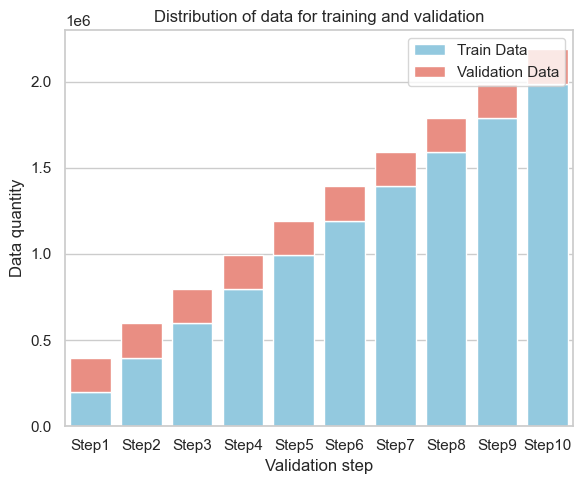

CPU times: total: 1.64 s
Wall time: 1.69 s


In [5]:
%%time
test_validation_class = Validation(
                 train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 n_splits=10,
                 model = RandomForestRegressor(max_depth=1, n_estimators=1, random_state=42, n_jobs=-1),
                 check_nans=True,
                 dropna = True,
                 validation_schema_plot=True
                )

In [6]:
%%time
test_validation_class.evaluate()

CPU times: total: 9.61 s
Wall time: 9.93 s


{'step1': {'Train/Validation error': [0.9526031628668, 1.3181425886531049],
  'Train/Validation limits': 'TRAIN: from 0 to  198979  (size: 198979 ) VALIDATION: from 198980 to  397957  (size: 198977 )',
  'Time for step': '0.18794655799865723 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation error': [1.0844371245438509, 8.754321124660649],
  'Train/Validation limits': 'TRAIN: from 0 to  397957  (size: 397957 ) VALIDATION: from 397958 to  596935  (size: 198977 )',
  'Time for step': '0.3493523597717285 s',
  '__________________': '_________________________________________________________________________________'},
 'step3': {'Train/Validation error': [2.3053655781907163, 5.8174809044426254],
  'Train/Validation limits': 'TRAIN: from 0 to  596935  (size: 596935 ) VALIDATION: from 596936 to  795913  (size: 198977 )',
  'Time for step': '0.5205228328704834 s',
  '__________________': '______________

In [7]:
%%time
test_validation_class.predict_target()

CPU times: total: 1.81 s
Wall time: 1.82 s


,ID,item_cnt_month
0,0,0.30
1,1,0.00
2,2,0.00
3,3,0.00
4,4,0.00
...,...,...
214195,214195,0.00
214196,214196,0.00
214197,214197,0.30
214198,214198,0.00


### Learn models

##### Random Forest Regressor

In [8]:
%%time
random_forest_regression = Validation(
                                 train_data=data['train_data'],
                                 test_data=data['test_data'],
                                 submission_example=data['submission_example'],
                                 n_splits=10,
                                 model = RandomForestRegressor(max_depth=4, n_estimators=25, random_state=42, n_jobs=-1),
                                 check_nans=True,
                                 dropna = True
                           )

Data is not sorted by time (5616 rows), it will be further sorted automatically
CPU times: total: 1.19 s
Wall time: 1.2 s


In [9]:
%%time
random_forest_report = random_forest_regression.evaluate()
random_forest_report

CPU times: total: 26min 2s
Wall time: 2min 39s


{'step1': {'Train/Validation error': [0.4941448853461927, 0.7582750854700758],
  'Train/Validation limits': 'TRAIN: from 0 to  198979  (size: 198979 ) VALIDATION: from 198980 to  397957  (size: 198977 )',
  'Time for step': '1.613933801651001 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation error': [0.581018391029274, 3.5693012568802263],
  'Train/Validation limits': 'TRAIN: from 0 to  397957  (size: 397957 ) VALIDATION: from 397958 to  596935  (size: 198977 )',
  'Time for step': '3.9422032833099365 s',
  '__________________': '_________________________________________________________________________________'},
 'step3': {'Train/Validation error': [0.6700329289487627, 1.776298249628479],
  'Train/Validation limits': 'TRAIN: from 0 to  596935  (size: 596935 ) VALIDATION: from 596936 to  795913  (size: 198977 )',
  'Time for step': '7.394965648651123 s',
  '__________________': '_______________

In [10]:
%%time
RandomForest_regression_submission = random_forest_regression.predict_target()

CPU times: total: 6min 3s
Wall time: 37.4 s


##### XGboost

In [11]:
%%time
XGB_regression = Validation(
                     train_data=data['train_data'],
                     test_data=data['test_data'],
                     submission_example=data['submission_example'],
                     n_splits=10,
                     model = XGBRegressor(n_estimators=15),
                     check_nans=False,
                     dropna = False
                 ) 

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 3.19 s
Wall time: 3.21 s


[0]	validation_0-rmse:1.72228	validation_1-rmse:1.84158
[14]	validation_0-rmse:1.45750	validation_1-rmse:2.18458
[0]	validation_0-rmse:1.68710	validation_1-rmse:1.81972
[14]	validation_0-rmse:1.36983	validation_1-rmse:1.42829
[0]	validation_0-rmse:1.73755	validation_1-rmse:2.22311
[14]	validation_0-rmse:1.33544	validation_1-rmse:1.71450
[0]	validation_0-rmse:1.85817	validation_1-rmse:2.01847
[14]	validation_0-rmse:1.38410	validation_1-rmse:1.57960
[0]	validation_0-rmse:1.89305	validation_1-rmse:1.90231
[14]	validation_0-rmse:1.40001	validation_1-rmse:1.43049
[0]	validation_0-rmse:1.90184	validation_1-rmse:1.53617
[14]	validation_0-rmse:1.37645	validation_1-rmse:1.01247
[0]	validation_0-rmse:1.85230	validation_1-rmse:2.27751
[14]	validation_0-rmse:1.33549	validation_1-rmse:1.69967
[0]	validation_0-rmse:1.89946	validation_1-rmse:2.08482
[14]	validation_0-rmse:1.36900	validation_1-rmse:1.56458
[0]	validation_0-rmse:1.92380	validation_1-rmse:1.66226
[14]	validation_0-rmse:1.36377	validatio

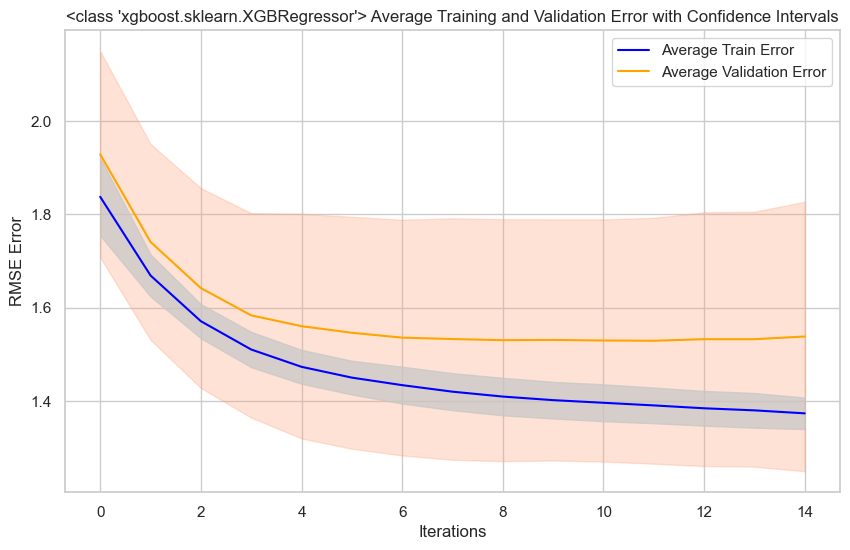

CPU times: total: 24min 3s
Wall time: 2min 55s


{'step1': {'Train/Validation error': [1.4575022314646082, 2.1845839480529943],
  'Train/Validation limits': 'TRAIN: from 0 to  991183  (size: 991183 ) VALIDATION: from 991184 to  1982357  (size: 991173 )',
  'Time for step': '7.150654554367065 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation error': [1.3698273685095592, 1.4282893471320632],
  'Train/Validation limits': 'TRAIN: from 0 to  1982357  (size: 1982357 ) VALIDATION: from 1982358 to  2973531  (size: 991173 )',
  'Time for step': '7.551690340042114 s',
  '__________________': '_________________________________________________________________________________'},
 'step3': {'Train/Validation error': [1.335443298760806, 1.7144961106582528],
  'Train/Validation limits': 'TRAIN: from 0 to  2973531  (size: 2973531 ) VALIDATION: from 2973532 to  3964705  (size: 991173 )',
  'Time for step': '9.26714539527893 s',
  '__________________': '_______

In [12]:
%%time
XGB_report = XGB_regression.evaluate()
XGB_report

In [13]:
%%time
XGB_regression_submission = XGB_regression.predict_target()

CPU times: total: 2min 54s
Wall time: 23.9 s


##### LightGBM

In [14]:
%%time

params = {
    "objective": "regression",  
    "metric": "rmse",           
    "num_leaves": 31,           
    "learning_rate": 0.05,      
    "verbosity": 1            
}

LightGBM_regression = Validation(
                     train_data=data['train_data'],
                     test_data=data['test_data'],
                     submission_example=data['submission_example'],
                     n_splits=10,
                     model = lgb.LGBMRegressor(n_estimators=20),
                     params=params,
                     check_nans=False,
                     dropna = False
                 ) 

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 5.66 s
Wall time: 7.14 s


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 991184, number of used features: 26
[LightGBM] [Info] Start training from score 0.370565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1982358, number of used features: 30
[LightGBM] [Info] Start training from score 0.329794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total

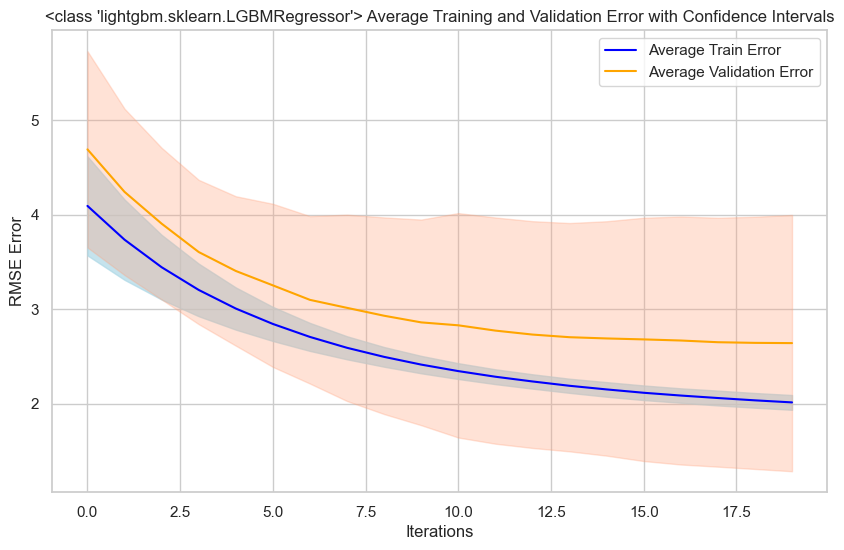

CPU times: total: 5min 8s
Wall time: 1min 13s


{'step1': {'Train/Validation error': [2.1510820920840614, 6.33458477971076],
  'Train/Validation limits': 'TRAIN: from 0 to  991183  (size: 991183 ) VALIDATION: from 991184 to  1982357  (size: 991173 )',
  'Time for step': '4.055896043777466 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation error': [1.9168903967840298, 2.8039024055762964],
  'Train/Validation limits': 'TRAIN: from 0 to  1982357  (size: 1982357 ) VALIDATION: from 1982358 to  2973531  (size: 991173 )',
  'Time for step': '3.702554941177368 s',
  '__________________': '_________________________________________________________________________________'},
 'step3': {'Train/Validation error': [1.9211730482772724, 2.773568996810665],
  'Train/Validation limits': 'TRAIN: from 0 to  2973531  (size: 2973531 ) VALIDATION: from 2973532 to  3964705  (size: 991173 )',
  'Time for step': '4.810600996017456 s',
  '__________________': '________

In [15]:
%%time
LightGBM_report = LightGBM_regression.evaluate()
LightGBM_report

In [16]:
%%time
LightGBM_regression_submission = LightGBM_regression.predict_target()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.963369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3674
[LightGBM] [Info] Number of data points in the train set: 10902924, number of used features: 32
[LightGBM] [Info] Start training from score 0.322979
CPU times: total: 49.4 s
Wall time: 20 s


##### Catboost

In [17]:
%%time
catboost_regression = Validation(
                 train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 n_splits=10,
                 model = cb.CatBoostRegressor(iterations=9, verbose=100),
                 check_nans=False,
                 dropna = False
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 4.66 s
Wall time: 6.12 s


Learning rate set to 0.5
0:	learn: 1.7121487	test: 1.7687908	best: 1.7687908 (0)	total: 209ms	remaining: 1.67s
8:	learn: 1.5681504	test: 1.7349737	best: 1.7109269 (1)	total: 692ms	remaining: 0us

bestTest = 1.710926937
bestIteration = 1

Shrink model to first 2 iterations.
Learning rate set to 0.5
0:	learn: 1.6698623	test: 1.7114135	best: 1.7114135 (0)	total: 126ms	remaining: 1.01s
8:	learn: 1.4182471	test: 1.4798009	best: 1.4719498 (3)	total: 1.12s	remaining: 0us

bestTest = 1.471949756
bestIteration = 3

Shrink model to first 4 iterations.
Learning rate set to 0.5
0:	learn: 1.6728186	test: 2.0448983	best: 2.0448983 (0)	total: 154ms	remaining: 1.23s
8:	learn: 1.4148106	test: 1.7390968	best: 1.7364162 (5)	total: 1.41s	remaining: 0us

bestTest = 1.7364162
bestIteration = 5

Shrink model to first 6 iterations.
Learning rate set to 0.5
0:	learn: 1.7747124	test: 1.8915082	best: 1.8915082 (0)	total: 191ms	remaining: 1.53s
8:	learn: 1.4668775	test: 1.5973240	best: 1.5799842 (6)	total: 1.79s	

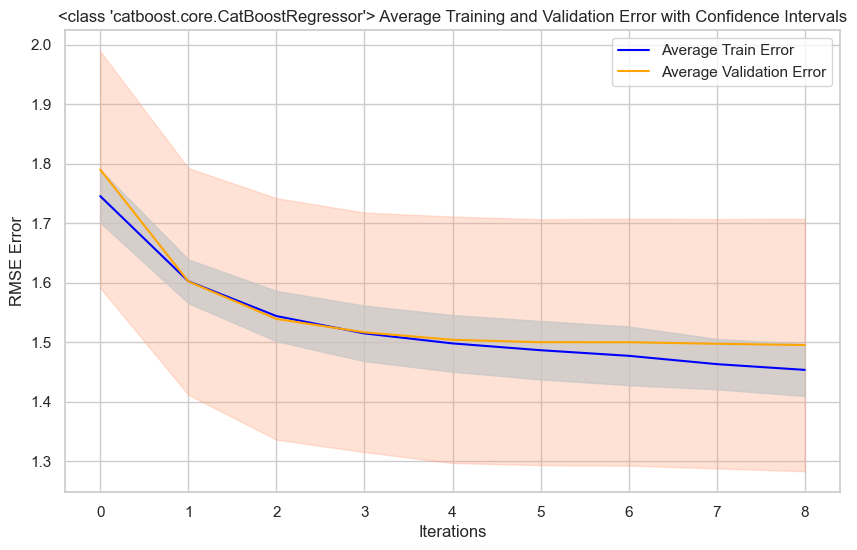

CPU times: total: 3min 39s
Wall time: 49.7 s


{'step1': {'Train/Validation error': [1.5681503666510286, 1.7349736985627535],
  'Train/Validation limits': 'TRAIN: from 0 to  991183  (size: 991183 ) VALIDATION: from 991184 to  1982357  (size: 991173 )',
  'Time for step': '1.6117072105407715 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation error': [1.4182470773251128, 1.4798008990855918],
  'Train/Validation limits': 'TRAIN: from 0 to  1982357  (size: 1982357 ) VALIDATION: from 1982358 to  2973531  (size: 991173 )',
  'Time for step': '2.3112199306488037 s',
  '__________________': '_________________________________________________________________________________'},
 'step3': {'Train/Validation error': [1.4148105643366868, 1.7390967717827588],
  'Train/Validation limits': 'TRAIN: from 0 to  2973531  (size: 2973531 ) VALIDATION: from 2973532 to  3964705  (size: 991173 )',
  'Time for step': '2.9910314083099365 s',
  '__________________': '__

In [18]:
%%time
CatBoost_report = catboost_regression.evaluate()
CatBoost_report

In [19]:
CatBoost_regression_submission = catboost_regression.predict_target()

Learning rate set to 0.5
0:	learn: 1.7723878	total: 468ms	remaining: 3.74s
8:	learn: 1.4241018	total: 5.18s	remaining: 0us


### Сomparison of models based on validation results

In [20]:
n_steps = 10

scores = pd.MultiIndex.from_product([["step " + str(i) for i in range(1, n_steps+1)],
                                  ['train_error', 'validation_error']],
                                 names=['Steps', 'RMSE'])
models = ['RandomForest', 'XGB', 'LightGBM', 'CatBoost']
df = pd.DataFrame('-', scores, models)

steps =  ["step" + str(i) for i in range(1, n_steps+1)]
reports = {'RandomForest': random_forest_report,
           'XGB':XGB_report,
           'LightGBM':LightGBM_report,
           'CatBoost':CatBoost_report
          }
for model, report in reports.items():
    temp = []
    for step in steps:
        temp.append(report[step]['Train/Validation error'][0])
        temp.append(report[step]['Train/Validation error'][1])
    df[model] = temp
df

RandomForest  XGB  LightGBM  CatBoost
Steps   RMSE                                                   
step 1  train_error               0.49 1.46      2.15      1.57
        validation_error          0.76 2.18      6.33      1.73
step 2  train_error               0.58 1.37      1.92      1.42
        validation_error          3.57 1.43      2.80      1.48
step 3  train_error               0.67 1.34      1.92      1.41
        validation_error          1.78 1.71      2.77      1.74
step 4  train_error               0.77 1.38      2.05      1.47
        validation_error          1.72 1.58      2.48      1.60
step 5  train_error               0.88 1.40      2.12      1.48
        validation_error          1.50 1.43      1.74      1.37
step 6  train_error               0.91 1.38      2.05      1.45
        validation_error          3.31 1.01      1.05      1.01
step 7  train_error               1.10 1.34      1.92      1.41
        validation_error          2.26 1.70      3.05      1.69
step 8  train_error               1.16 1.37      2.00      1.45
        validation_error          4.52 1.56      2.27      1.54
step 9  train_error               1.32 1.36      2.00      1.44
        validation_error          1.03 1.45      2.13      1.47
step 10 train_error               1.32 1.35      1.99      1.44
        validation_error          0.89 1.32      1.78      1.33

### Learning curve for models

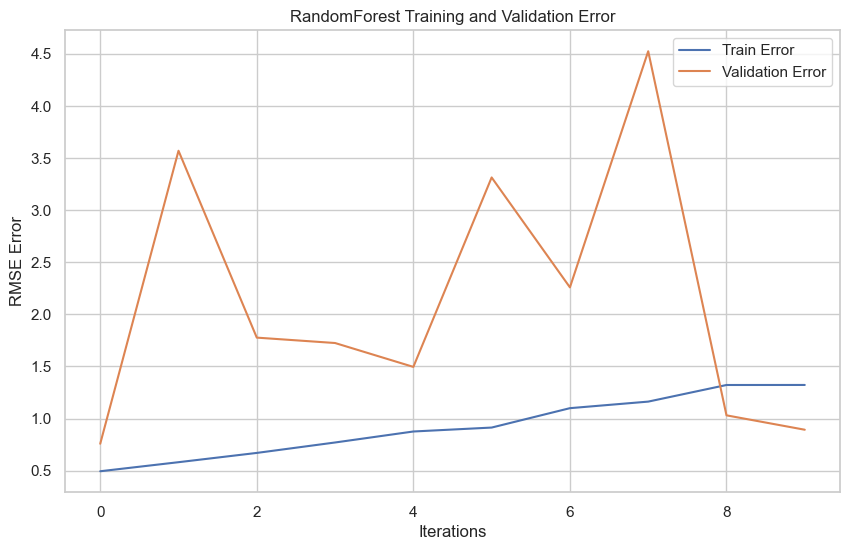

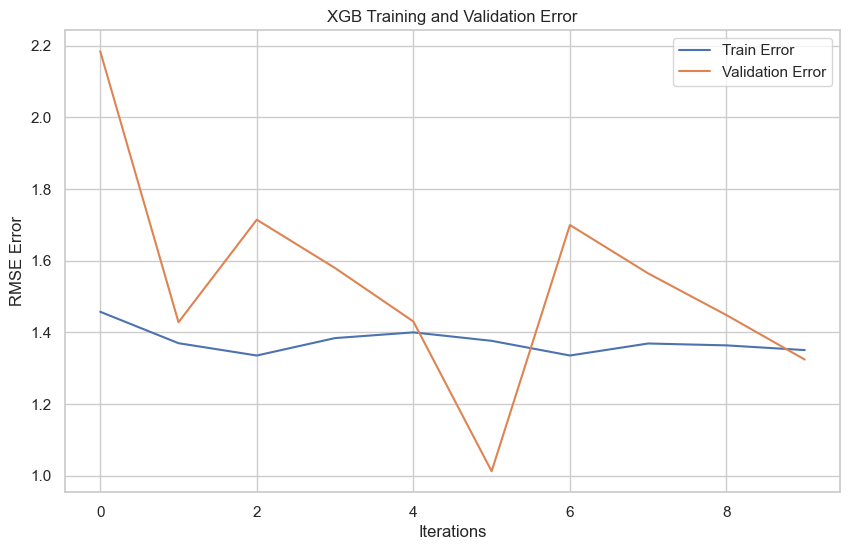

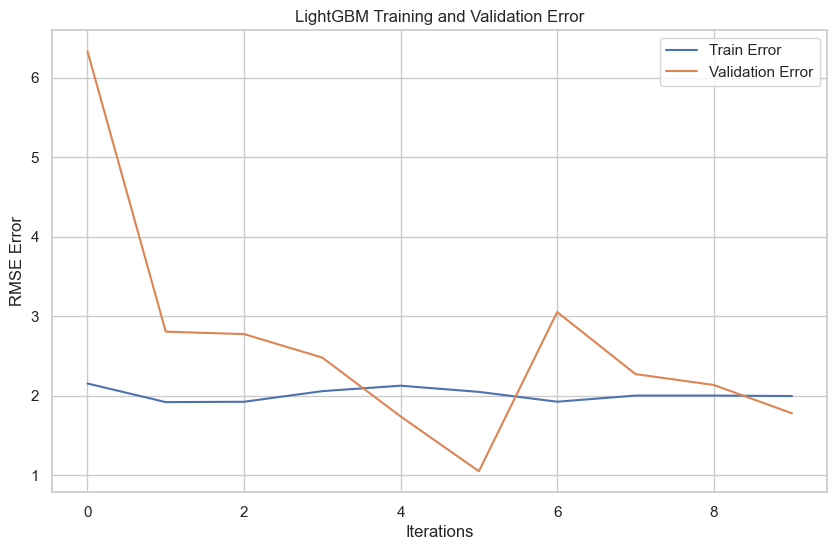

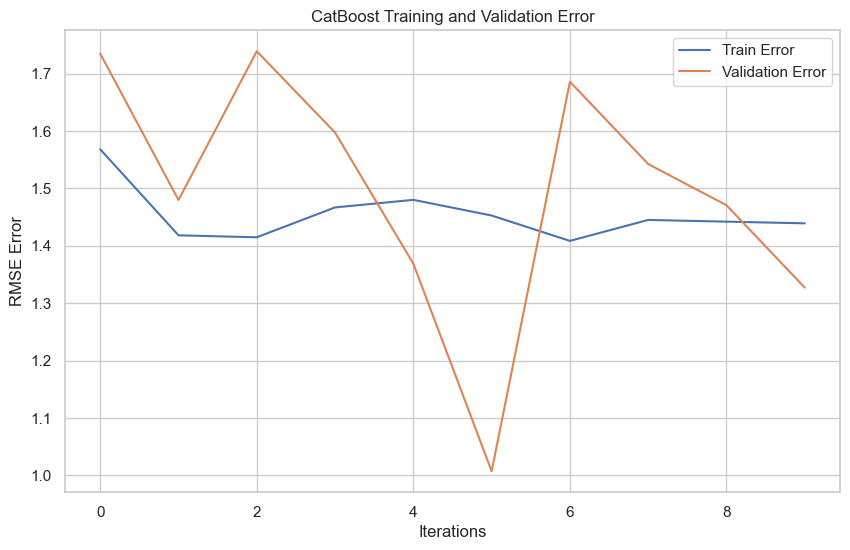

In [21]:
for model in df.columns:
    temp = df[model].reset_index()
    train_error = temp[temp.RMSE=='train_error'].iloc[:, 2].values
    val_error = temp[temp.RMSE=='validation_error'].iloc[:, 2].values

    plt.figure(figsize=(10, 6))
    plt.plot(train_error, label='Train Error')
    plt.plot(val_error, label='Validation Error')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE Error')
    plt.legend()
    plt.title(f'{model} Training and Validation Error')
    plt.show()

### Save submission results

In [22]:
submission_data = {
    'RF_submission' : RandomForest_regression_submission,
    'XGB_submission' : XGB_regression_submission,
    'LightGBM_submission' : LightGBM_regression_submission,
    'CatBoost_submission' : CatBoost_regression_submission
}

In [23]:
%%time
# get directory path
dirpath = os.getcwd()

# add path to load 
path_to_load = Path(dirpath) / 'data' / 'baseline_submissions'
os.makedirs(path_to_load, exist_ok=True)

# write data
for filename, df in submission_data.items():
    filepath = path_to_load / (filename + ".csv")
    with open(filepath, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(df)

CPU times: total: 0 ns
Wall time: 11 ms


In [24]:
from os import listdir
from os.path import isfile, join
print(*[f+"\n" for f in listdir(path_to_load) if isfile(join(path_to_load, f))])

CatBoost_submission.csv
 LightGBM_submission.csv
 RF_submission.csv
 XGB_submission.csv



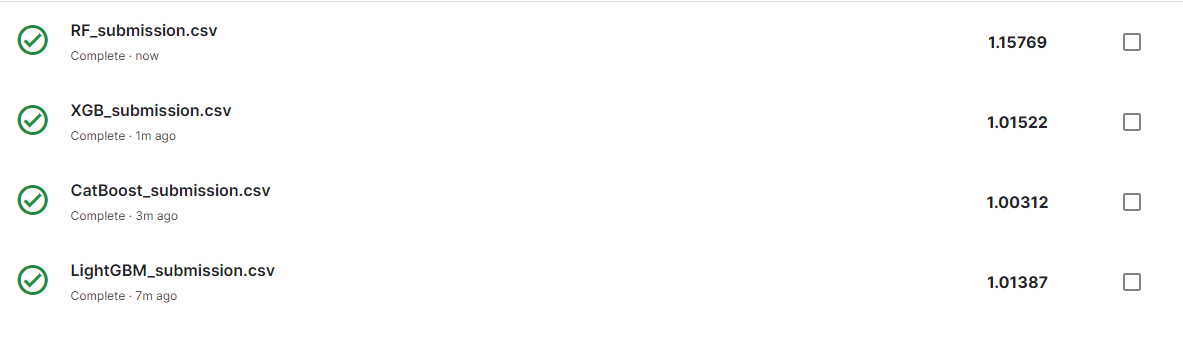